## Part 1: Why Multi-Agent Systems?

### The Limitation of Single Agents

Single agents work well for focused tasks, but struggle with:
- **Complex workflows** requiring diverse expertise
- **Large tool sets** (too many tools → confused LLM)
- **Specialized knowledge** in different domains

### Multi-Agent Solution

**Multi-agent systems** divide work among specialized agents, each with:
- Focused prompt/persona
- Relevant tools subset
- Clear responsibility

```
SINGLE AGENT (Overloaded)
═══════════════════════════════════════

    ┌─────────────────────────────────┐
    │        ONE AGENT                │
    │   20+ tools, generic prompt     │
    │   "Jack of all trades"          │
    └─────────────────────────────────┘
              ⚠️ Confused!


MULTI-AGENT (Specialized)
═══════════════════════════════════════

    ┌──────────┐ ┌──────────┐ ┌──────────┐
    │ Research │ │ Writing  │ │ Review   │
    │  Agent   │ │  Agent   │ │  Agent   │
    │ 3 tools  │ │ 2 tools  │ │ 2 tools  │
    └──────────┘ └──────────┘ └──────────┘
              ✅ Focused!
```

### Multi-Agent Architectures

There are several patterns for coordinating multiple agents:

| Pattern | Description | Best For |
|---------|-------------|----------|
| **Supervisor** | Central agent orchestrates workers | Clear hierarchy, diverse tasks |
| **Hierarchical** | Multi-level supervisors | Complex organizations |
| **Handoffs** | Agents pass control to each other | Sequential specialist work |
| **Collaborative** | Agents work together as peers | Brainstorming, consensus |

---

## Setup

In [1]:
%run ../setup_llm.py


🚀 LLM Setup Utility Test

🔍 Checking LLM Configuration...
📡 Provider: OpenAI (Direct)
✅ OPENAI_API_KEY is set

📋 Configuration:
   OPENAI_MODEL_NAME: gpt-4o

✅ OpenAI setup verified successfully!

📝 Testing model initialization...
✅ Model created: gpt-4o via OpenAI
✅ Test response: Hello!


In [2]:
import sys
sys.path.insert(0, '..')  # Add parent directory to path for setup_llm

from setup_llm import get_chat_model  # Use LLM helper
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langchain.agents import create_agent  # LangChain v1.0 - new standard for building agents
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Literal, List
import operator
import os

# Initialize model
# Initialize model using DIAL (Azure OpenAI)
model = get_chat_model(temperature=0)

print("✅ Environment ready")


✅ Environment ready


---

## Part 2: The Supervisor Pattern

### How It Works

A **Supervisor Agent** acts as a manager:
1. Receives the user request
2. Decides which worker agent to invoke
3. Routes to the appropriate worker
4. Collects results and continues or finishes

```
SUPERVISOR PATTERN
══════════════════════════════════════════════════════════════

                         User Request
                              │
                              ▼
                    ┌──────────────────┐
                    │   SUPERVISOR     │
                    │  "Who should     │◄──────────────┐
                    │   handle this?"  │               │
                    └────────┬─────────┘               │
                             │                         │
          ┌──────────────────┼──────────────────┐      │
          ▼                  ▼                  ▼      │
    ┌──────────┐      ┌──────────┐      ┌──────────┐   │
    │ Research │      │ Writing  │      │ Coder    │   │
    │  Agent   │      │  Agent   │      │  Agent   │   │
    └────┬─────┘      └────┬─────┘      └────┬─────┘   │
          │                  │                  │      │
          └──────────────────┴──────────────────┘      │
                             │                         │
                             └─────────────────────────┘
                                  (Loop until done)
```

### Building a Travel Planning Supervisor

Let's create a supervisor that coordinates:
- **Flight Agent**: Searches and books flights
- **Hotel Agent**: Finds accommodations
- **Activities Agent**: Suggests things to do

In [3]:
# Define tools for each specialized agent

@tool
def search_flights(origin: str, destination: str, date: str) -> str:
    """Search for available flights between cities on a specific date."""
    flights = [
        f"Flight A: {origin} → {destination} at 08:00 ($450)",
        f"Flight B: {origin} → {destination} at 14:30 ($380)",
        f"Flight C: {origin} → {destination} at 20:00 ($420)"
    ]
    return f"Found {len(flights)} flights on {date}:\n" + "\n".join(flights)

@tool
def book_flight(flight_id: str, passengers: int) -> str:
    """Book a specific flight for the given number of passengers."""
    return f"✅ Booked {flight_id} for {passengers} passengers. Confirmation: FL{hash(flight_id) % 10000}"

@tool
def search_hotels(city: str, checkin: str, checkout: str) -> str:
    """Search for hotels in a city for given dates."""
    hotels = [
        f"Grand Hotel {city}: $200/night, 4.5★",
        f"Budget Inn {city}: $80/night, 3.8★",
        f"Luxury Resort {city}: $450/night, 4.9★"
    ]
    return f"Hotels in {city} ({checkin} to {checkout}):\n" + "\n".join(hotels)

@tool
def book_hotel(hotel_name: str, nights: int) -> str:
    """Book a hotel for the specified number of nights."""
    return f"✅ Booked {hotel_name} for {nights} nights. Confirmation: HT{hash(hotel_name) % 10000}"

@tool
def search_activities(city: str, interests: str) -> str:
    """Find activities and attractions in a city based on interests."""
    activities = {
        "culture": ["Art Museum Tour", "Historical Walking Tour", "Local Theater Show"],
        "adventure": ["Zip-lining Experience", "Kayaking Tour", "Mountain Hiking"],
        "food": ["Food Walking Tour", "Cooking Class", "Wine Tasting"]
    }
    found = activities.get(interests.lower(), ["City Tour", "Local Market Visit"])
    return f"Activities in {city} for {interests}:\n" + "\n".join(f"• {a}" for a in found)

print("✅ Travel tools defined")

✅ Travel tools defined


In [4]:
# Create specialized agents using create_agent (LangChain v1.0)
# Use system_prompt parameter for the agent's behavior instructions

flight_agent = create_agent(
    model=model,
    tools=[search_flights, book_flight],
    system_prompt="You are a flight specialist. Help users find and book flights."
)

hotel_agent = create_agent(
    model=model,
    tools=[search_hotels, book_hotel],
    system_prompt="You are a hotel specialist. Help users find and book accommodations."
)

activities_agent = create_agent(
    model=model,
    tools=[search_activities],
    system_prompt="You are an activities specialist. Suggest fun things to do based on interests."
)

print("✅ Specialized agents created:")
print("   - Flight Agent (search_flights, book_flight)")
print("   - Hotel Agent (search_hotels, book_hotel)")
print("   - Activities Agent (search_activities)")

✅ Specialized agents created:
   - Flight Agent (search_flights, book_flight)
   - Hotel Agent (search_hotels, book_hotel)
   - Activities Agent (search_activities)


In [5]:
from pydantic import BaseModel, Field
from enum import Enum

# Define routing options
class AgentChoice(str, Enum):
    FLIGHT = "flight"
    HOTEL = "hotel"
    ACTIVITIES = "activities"
    FINISH = "finish"

class SupervisorDecision(BaseModel):
    """Supervisor's routing decision"""
    next_agent: AgentChoice = Field(description="Which agent should handle the next step")
    task: str = Field(description="What task should the agent perform")
    reasoning: str = Field(description="Why this agent was chosen")

# Create supervisor with structured output
# Use method="function_calling" for DIAL/Azure OpenAI compatibility
supervisor_llm = model.with_structured_output(SupervisorDecision, method="function_calling")

print("✅ Supervisor decision model ready")

✅ Supervisor decision model ready


In [6]:
# Define state for the supervisor graph
class TravelPlannerState(TypedDict):
    messages: Annotated[list, operator.add]
    next_agent: str
    task: str

# Track which agents have been called
agents_called = set()

# Supervisor node
def supervisor_node(state: TravelPlannerState) -> dict:
    """Supervisor decides which agent to call next"""
    global agents_called
    
    # Build context from conversation
    conversation = "\n".join([
        f"{m.type}: {m.content[:300]}" 
        for m in state["messages"][-10:]  # Last 10 messages for context
        if hasattr(m, 'content') and m.content
    ])
    
    # Track what's been done
    agents_used = ", ".join(agents_called) if agents_called else "none"
    
    decision = supervisor_llm.invoke([
        SystemMessage(content=f"""You are a travel planning supervisor managing a team of agents:
- flight: Searches and books flights
- hotel: Finds and books hotels  
- activities: Suggests things to do
- finish: Complete the planning when ALL requested items are addressed

IMPORTANT RULES:
1. The user requested: flights, hotel for 3 nights, and cultural activities
2. Agents already used: {agents_used}
3. Each agent should only be called ONCE
4. After all three agents (flight, hotel, activities) have responded, choose 'finish'
5. If an agent has already been used, do NOT call it again

Choose 'finish' if flights, hotel, and activities have all been addressed."""),
        HumanMessage(content=f"Conversation so far:\n{conversation}\n\nAgents already called: {agents_used}\nWhat should we do next?")
    ])
    
    # Track this decision
    if decision.next_agent.value != "finish":
        agents_called.add(decision.next_agent.value)
    
    return {
        "next_agent": decision.next_agent.value,
        "task": decision.task,
        "messages": [AIMessage(content=f"[Supervisor] Routing to {decision.next_agent.value}: {decision.reasoning}")]
    }

# Worker nodes
def flight_node(state: TravelPlannerState) -> dict:
    """Flight agent processes the task"""
    result = flight_agent.invoke({"messages": state["messages"] + [HumanMessage(content=state["task"])]})
    return {"messages": [AIMessage(content=f"[Flight Agent] {result['messages'][-1].content}")]}

def hotel_node(state: TravelPlannerState) -> dict:
    """Hotel agent processes the task"""
    result = hotel_agent.invoke({"messages": state["messages"] + [HumanMessage(content=state["task"])]})
    return {"messages": [AIMessage(content=f"[Hotel Agent] {result['messages'][-1].content}")]}

def activities_node(state: TravelPlannerState) -> dict:
    """Activities agent processes the task"""
    result = activities_agent.invoke({"messages": state["messages"] + [HumanMessage(content=state["task"])]})
    return {"messages": [AIMessage(content=f"[Activities Agent] {result['messages'][-1].content}")]}

print("✅ Node functions defined")

✅ Node functions defined


In [7]:
# Build the supervisor graph
supervisor_builder = StateGraph(TravelPlannerState)

# Add nodes
supervisor_builder.add_node("supervisor", supervisor_node)
supervisor_builder.add_node("flight", flight_node)
supervisor_builder.add_node("hotel", hotel_node)
supervisor_builder.add_node("activities", activities_node)

# Routing function
def route_to_agent(state: TravelPlannerState) -> Literal["flight", "hotel", "activities", "__end__"]:
    if state["next_agent"] == "finish":
        return "__end__"
    return state["next_agent"]

# Add edges
supervisor_builder.add_edge(START, "supervisor")

supervisor_builder.add_conditional_edges(
    "supervisor",
    route_to_agent,
    {
        "flight": "flight",
        "hotel": "hotel",
        "activities": "activities",
        "__end__": END
    }
)

# All workers go back to supervisor
supervisor_builder.add_edge("flight", "supervisor")
supervisor_builder.add_edge("hotel", "supervisor")
supervisor_builder.add_edge("activities", "supervisor")

# Compile
travel_supervisor = supervisor_builder.compile()

print("✅ Supervisor graph compiled")

✅ Supervisor graph compiled


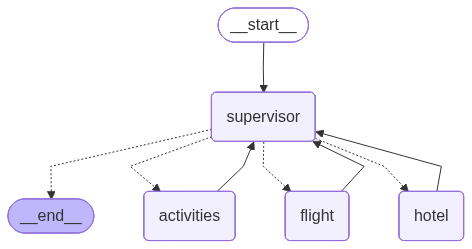

In [8]:
# Visualize
from IPython.display import Image, display

try:
    display(Image(travel_supervisor.get_graph().draw_mermaid_png()))
except Exception:
    print(travel_supervisor.get_graph().draw_mermaid())

In [9]:
# Test the supervisor
print("🌴 TRAVEL PLANNING SUPERVISOR DEMO")
print("=" * 60)

# Reset the tracking
agents_called.clear()

# Invoke with a higher recursion limit as safety net
result = travel_supervisor.invoke(
    {
        "messages": [HumanMessage(content="I want to plan a trip from Singapore to Tokyo next month. I need flights, a hotel for 3 nights, and some cultural activities.")],
        "next_agent": "",
        "task": ""
    },
    config={"recursion_limit": 15}  # Allow up to 15 steps (supervisor + 3 agents * 2 each + buffer)
)

print("\n📋 PLANNING RESULTS:")
print("-" * 60)

for msg in result["messages"]:
    if hasattr(msg, 'content') and msg.content:
        print(f"\n{msg.content[:500]}" + ("..." if len(msg.content) > 500 else ""))

🌴 TRAVEL PLANNING SUPERVISOR DEMO

📋 PLANNING RESULTS:
------------------------------------------------------------

I want to plan a trip from Singapore to Tokyo next month. I need flights, a hotel for 3 nights, and some cultural activities.

[Supervisor] Routing to flight: The user needs flights as part of their trip planning, and it's logical to start with booking flights to ensure availability and fit the rest of the itinerary around the travel dates.

[Flight Agent] Please provide the specific date you would like to fly from Singapore to Tokyo, and let me know how many passengers will be traveling.

[Supervisor] Routing to hotel: The user requested a hotel for 3 nights, and since the flight agent has already been used, the next logical step is to book accommodation to ensure availability during the stay.

[Hotel Agent] Please provide the check-in and check-out dates for your stay in Tokyo, so I can find and book a suitable hotel for you.

[Supervisor] Routing to activities: The us

---

## Part 3: Agent Handoffs

### What are Handoffs?

**Handoffs** allow one agent to transfer control directly to another agent, without going through a supervisor.

```
HANDOFF PATTERN
══════════════════════════════════════════════════════════════

    User Request
         │
         ▼
   ┌──────────┐     handoff()    ┌──────────┐
   │ Agent A  │ ───────────────► │ Agent B  │
   │ (Intake) │                  │(Specialist)│
   └──────────┘                  └────┬─────┘
                                      │
                                      ▼
                                   Response
```

### When to Use Handoffs

- Sequential specialist processing
- When agents need to "tag out" to experts
- Escalation patterns (e.g., bot → human)
- Simpler than full supervisor when flow is predictable

In [10]:
# Pattern 2: Simpler Agent Handoff using conditional routing
# Instead of Command-based handoffs, we use structured output to route between agents

class HandoffDecision(BaseModel):
    """Decides where to route the conversation"""
    target: Literal["sales", "support", "done"] = Field(
        description="sales for pricing/purchasing, support for technical issues, done when resolved"
    )
    reason: str = Field(description="Why routing to this target")

# Create a router model
router_model = model.with_structured_output(HandoffDecision, method="function_calling")

print("✅ Handoff routing model ready")

✅ Handoff routing model ready


In [11]:
# Specialist tools for each domain
@tool
def check_pricing(product: str) -> str:
    """Check the pricing for a product."""
    prices = {
        "basic": "$29/month",
        "pro": "$99/month",
        "enterprise": "Custom pricing"
    }
    return f"{product}: {prices.get(product.lower(), 'Contact sales for pricing')}"

@tool
def create_quote(product: str, quantity: int) -> str:
    """Create a price quote for a product."""
    return f"Quote created: {quantity}x {product}. A sales rep will contact you within 24 hours."

@tool
def check_system_status() -> str:
    """Check current system status and known issues."""
    return "All systems operational. No known issues."

@tool
def run_diagnostics(issue_type: str) -> str:
    """Run diagnostics for common issues."""
    diagnostics = {
        "login": "Clear browser cache and cookies. Try incognito mode.",
        "performance": "Check internet connection. Disable browser extensions.",
        "error": "Note the error code. Check our status page."
    }
    return diagnostics.get(issue_type.lower(), "Please describe the issue in more detail.")

print("✅ Specialist tools defined")

✅ Specialist tools defined


In [12]:
# Create specialized agents - each focuses on their domain
sales_tools = [check_pricing, create_quote]
support_tools = [check_system_status, run_diagnostics]

sales_agent = create_agent(
    model=model,
    tools=sales_tools,
    system_prompt="""You are a Sales Agent. Help customers with:
- Pricing information
- Product comparisons  
- Creating quotes

Provide helpful, accurate information about our products."""
)

support_agent = create_agent(
    model=model,
    tools=support_tools,
    system_prompt="""You are a Technical Support Agent. Help customers with:
- Troubleshooting issues
- Checking system status
- Running diagnostics

Be patient and thorough in helping resolve technical issues."""
)

print("✅ Sales and Support agents created")

✅ Sales and Support agents created


In [13]:
# Build handoff graph with router pattern
class HandoffState(TypedDict):
    messages: Annotated[list, operator.add]
    route: str

def triage_node(state: HandoffState) -> dict:
    """Route the conversation to the right specialist"""
    messages = state["messages"]
    
    system_prompt = """Analyze the customer's message and decide where to route:
- 'sales' for pricing, purchasing, upgrades, or product questions
- 'support' for technical issues, errors, bugs, or troubleshooting
- 'done' if the issue is already resolved"""
    
    decision = router_model.invoke([
        SystemMessage(content=system_prompt),
        *messages
    ])
    
    return {
        "messages": [AIMessage(content=f"[Triage] Routing to {decision.target}: {decision.reason}")],
        "route": decision.target
    }

def sales_node(state: HandoffState) -> dict:
    """Sales agent handles the conversation"""
    result = sales_agent.invoke({"messages": state["messages"]})
    return {"messages": result["messages"]}

def support_node(state: HandoffState) -> dict:
    """Support agent handles the conversation"""
    result = support_agent.invoke({"messages": state["messages"]})
    return {"messages": result["messages"]}

def route_decision(state: HandoffState) -> str:
    """Route based on triage decision"""
    return state.get("route", "done")

# Build the graph
handoff_builder = StateGraph(HandoffState)
handoff_builder.add_node("triage", triage_node)
handoff_builder.add_node("sales", sales_node)
handoff_builder.add_node("support", support_node)

handoff_builder.add_edge(START, "triage")
handoff_builder.add_conditional_edges(
    "triage",
    route_decision,
    {"sales": "sales", "support": "support", "done": END}
)
handoff_builder.add_edge("sales", END)
handoff_builder.add_edge("support", END)

handoff_graph = handoff_builder.compile()

print("✅ Handoff graph with routing compiled")

✅ Handoff graph with routing compiled


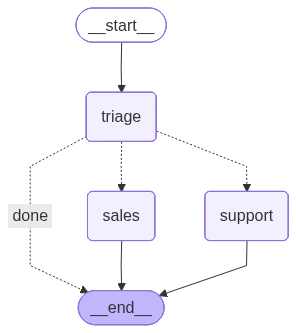

In [14]:
# Visualize
from IPython.display import Image, display

try:
    display(Image(handoff_graph.get_graph().draw_mermaid_png()))
except Exception:
    print(handoff_graph.get_graph().draw_mermaid())

In [15]:
# Test handoff flow - Sales inquiry
print("🤝 HANDOFF DEMO: Sales Inquiry")
print("=" * 60)

result = handoff_graph.invoke({
    "messages": [HumanMessage(content="Hi, I'm interested in upgrading to the Pro plan. Can you tell me the pricing?")],
    "route": ""
})

print("\nConversation Flow:")
for msg in result["messages"]:
    if isinstance(msg, HumanMessage):
        print(f"\n👤 Customer: {msg.content}")
    elif isinstance(msg, AIMessage) and msg.content:
        content = msg.content[:400] + "..." if len(msg.content) > 400 else msg.content
        print(f"\n🤖 Agent: {content}")

🤝 HANDOFF DEMO: Sales Inquiry

Conversation Flow:

👤 Customer: Hi, I'm interested in upgrading to the Pro plan. Can you tell me the pricing?

🤖 Agent: [Triage] Routing to sales: The customer is inquiring about pricing for upgrading to the Pro plan, which falls under sales inquiries.

👤 Customer: Hi, I'm interested in upgrading to the Pro plan. Can you tell me the pricing?

🤖 Agent: [Triage] Routing to sales: The customer is inquiring about pricing for upgrading to the Pro plan, which falls under sales inquiries.

🤖 Agent: The pricing for the Pro plan requires contacting our sales team directly. Would you like me to assist you in getting a quote or connecting you with a sales representative?


In [16]:
# Test handoff flow - Technical support
print("\n" + "=" * 60)
print("🤝 HANDOFF DEMO: Technical Issue")
print("=" * 60)

result = handoff_graph.invoke({
    "messages": [HumanMessage(content="I can't log into my account. It keeps showing an error.")],
    "route": ""
})

print("\nConversation Flow:")
for msg in result["messages"]:
    if isinstance(msg, HumanMessage):
        print(f"\n👤 Customer: {msg.content}")
    elif isinstance(msg, AIMessage) and msg.content:
        content = msg.content[:400] + "..." if len(msg.content) > 400 else msg.content
        print(f"\n🤖 Agent: {content}")


🤝 HANDOFF DEMO: Technical Issue

Conversation Flow:

👤 Customer: I can't log into my account. It keeps showing an error.

🤖 Agent: [Triage] Routing to support: The customer is experiencing a login error, which is a technical issue that requires troubleshooting.

👤 Customer: I can't log into my account. It keeps showing an error.

🤖 Agent: [Triage] Routing to support: The customer is experiencing a login error, which is a technical issue that requires troubleshooting.

🤖 Agent: I'm sorry to hear you're having trouble logging into your account. Let's try to resolve this issue. I'll start by checking the system status for any known issues and running diagnostics for common login problems. Please hold on for a moment.

🤖 Agent: Here's what I found:

1. **System Status**: All systems are operational, and there are no known issues affecting logins.

2. **Diagnostics Suggestion**: It might help to clear your browser's cache and cookies. Additionally, try logging in using an incognito or priv

---

## Part 4: Planning with Multi-Agent Systems

### The Planning Agent Pattern

A **Planning Agent** creates a structured plan and delegates to specialized workers.

```
PLANNING PATTERN
══════════════════════════════════════════════════════════════

    User Goal
        │
        ▼
  ┌──────────────┐
  │   PLANNER    │  Creates structured plan
  │    Agent     │  with subtasks and assignments
  └──────┬───────┘
         │
         ▼
  ┌──────────────┐
  │  Subtask 1   │ ──► Worker A
  │  Subtask 2   │ ──► Worker B
  │  Subtask 3   │ ──► Worker A
  └──────────────┘
         │
         ▼
     Combined Result
```

In [17]:
from pydantic import BaseModel, Field
from typing import List
from enum import Enum

# Define available agents
class WorkerType(str, Enum):
    RESEARCHER = "researcher"
    WRITER = "writer"
    REVIEWER = "reviewer"

class Subtask(BaseModel):
    """A single subtask in the plan"""
    task_id: int = Field(description="Unique task ID")
    description: str = Field(description="What needs to be done")
    assigned_to: WorkerType = Field(description="Which worker handles this")
    depends_on: List[int] = Field(default=[], description="Task IDs this depends on")

class ExecutionPlan(BaseModel):
    """Complete plan for achieving the goal"""
    goal: str = Field(description="The main goal")
    subtasks: List[Subtask] = Field(description="Ordered list of subtasks")
    estimated_time: str = Field(description="Estimated completion time")

print("✅ Planning models defined")

✅ Planning models defined


In [18]:
# Create the planner with function_calling method for DIAL compatibility
planner_llm = model.with_structured_output(ExecutionPlan, method="function_calling")

def create_plan(goal: str) -> ExecutionPlan:
    """Create an execution plan for a goal"""
    plan = planner_llm.invoke([
        SystemMessage(content="""You are a planning agent. Create execution plans using these workers:

- researcher: Gathers information, does web searches, finds facts
- writer: Creates content, drafts documents, writes summaries
- reviewer: Checks quality, provides feedback, suggests improvements

Create a logical sequence of subtasks. Consider dependencies."""),
        HumanMessage(content=f"Create a plan to: {goal}")
    ])
    return plan

# Test the planner
sample_goal = "Write a blog post about the benefits of AI in healthcare"

plan = create_plan(sample_goal)

print("📋 EXECUTION PLAN")
print("=" * 60)
print(f"\nGoal: {plan.goal}")
print(f"Estimated Time: {plan.estimated_time}")
print(f"\nSubtasks ({len(plan.subtasks)} total):")

for task in plan.subtasks:
    deps = f" (depends on: {task.depends_on})" if task.depends_on else ""
    print(f"\n  {task.task_id}. [{task.assigned_to.value.upper()}]{deps}")
    print(f"     {task.description}")

📋 EXECUTION PLAN

Goal: Write a blog post about the benefits of AI in healthcare
Estimated Time: 3 days

Subtasks (8 total):

  1. [RESEARCHER]
     Research the current applications of AI in healthcare.

  2. [RESEARCHER]
     Research the benefits of AI in healthcare, including patient outcomes, cost reduction, and efficiency improvements.

  3. [RESEARCHER]
     Research potential challenges and ethical considerations of using AI in healthcare.

  4. [WRITER] (depends on: [1, 2, 3])
     Draft an outline for the blog post based on the research findings.

  5. [WRITER] (depends on: [4])
     Write the introduction and conclusion for the blog post.

  6. [WRITER] (depends on: [4])
     Write the main content of the blog post, detailing the benefits of AI in healthcare.

  7. [REVIEWER] (depends on: [5, 6])
     Review the entire blog post for coherence, accuracy, and engagement.

  8. [WRITER] (depends on: [7])
     Make necessary revisions based on reviewer feedback.


In [19]:
# Visualize the plan as a task dependency graph
from collections import defaultdict

# Group tasks by worker
tasks_by_worker = defaultdict(list)
for task in plan.subtasks:
    tasks_by_worker[task.assigned_to.value].append(task)

print("\n👥 WORKLOAD DISTRIBUTION:")
print("-" * 40)

for worker, tasks in tasks_by_worker.items():
    print(f"\n{worker.upper()} ({len(tasks)} tasks):")
    for task in tasks:
        print(f"  • Task {task.task_id}: {task.description[:50]}...")


👥 WORKLOAD DISTRIBUTION:
----------------------------------------

RESEARCHER (3 tasks):
  • Task 1: Research the current applications of AI in healthc...
  • Task 2: Research the benefits of AI in healthcare, includi...
  • Task 3: Research potential challenges and ethical consider...

WRITER (4 tasks):
  • Task 4: Draft an outline for the blog post based on the re...
  • Task 5: Write the introduction and conclusion for the blog...
  • Task 6: Write the main content of the blog post, detailing...
  • Task 8: Make necessary revisions based on reviewer feedbac...

REVIEWER (1 tasks):
  • Task 7: Review the entire blog post for coherence, accurac...


---

## 🎯 Key Takeaways

### Multi-Agent Patterns

| Pattern | Structure | Best For |
|---------|-----------|----------|
| **Supervisor** | Central orchestrator + workers | Complex tasks, diverse specialists |
| **Handoffs** | Agent-to-agent transfers | Sequential specialists, escalation |
| **Planning** | Planner creates structured tasks | Goal decomposition, coordinated work |

### When to Use Multi-Agent

✅ **Use Multi-Agent When:**
- Single agent has too many tools (>10)
- Tasks require diverse expertise
- Need separation of concerns
- Complex workflows with specialists

❌ **Avoid Multi-Agent When:**
- Simple, focused tasks
- Low latency requirements (more agents = more calls)
- Budget constraints (each agent = more LLM calls)

### Implementation Tips

1. **Start Simple**: Single agent first, split when needed
2. **Clear Responsibilities**: Each agent has a focused role
3. **Explicit Routing**: Make handoff/routing logic clear
4. **Test Thoroughly**: Multi-agent systems have more failure modes

### What's Next

In **Module 4**, we'll explore **Framework Comparison**:
- LangGraph vs. other frameworks
- When to use what
- Production considerations

---

## Practice Exercise

**Challenge**: Build a content creation multi-agent system with:

1. **Idea Generator Agent**: Creates content ideas
2. **Writer Agent**: Drafts content
3. **Editor Agent**: Reviews and improves
4. **Supervisor**: Orchestrates the workflow

Flow: User provides topic → Ideas → Draft → Edit → Final

In [20]:
# Your solution here:

# TODO: Define tools for each agent

# TODO: Create specialized agents

# TODO: Build supervisor graph

# TODO: Test with a topic

print("💡 Implement your content creation system above!")

💡 Implement your content creation system above!
